# Sentiment Analysis with NLP

In [11]:
!pip install --quiet datasets transformers scikit-learn matplotlib tqdm

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tqdm.notebook import tqdm

plt.rcParams['figure.figsize'] = (6, 6)


## 1  Load and Explore Data

In [3]:
# Using the IMDb movie‑reviews dataset (50k labeled samples)
imdb = load_dataset('imdb')
train_ds = imdb['train']
test_ds  = imdb['test']

print(train_ds)
print(train_ds.features)

Dataset({
    features: ['text', 'label'],
    num_rows: 25000
})
{'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['neg', 'pos'], id=None)}


In [4]:
# Label distribution
labels, counts = np.unique(train_ds['label'], return_counts=True)
for l, c in zip(labels, counts):
    print(f"Label {l}: {c} samples")


Label 0: 12500 samples
Label 1: 12500 samples


## 2  Classical ML Pipeline

In [5]:
# Vectorize with TF‑IDF (unigrams + bigrams)
vectorizer = TfidfVectorizer(max_features=20000, ngram_range=(1,2), stop_words='english')

# Fit on train text only
X_train = vectorizer.fit_transform(train_ds['text'])
y_train = np.array(train_ds['label'])

# Transform test text
X_test  = vectorizer.transform(test_ds['text'])
y_test  = np.array(test_ds['label'])

print(f"Train matrix: {X_train.shape}, Test matrix: {X_test.shape}")

Train matrix: (25000, 20000), Test matrix: (25000, 20000)


In [6]:
clf = LogisticRegression(max_iter=1000, n_jobs=-1)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['negative', 'positive']))

              precision    recall  f1-score   support

    negative       0.88      0.88      0.88     12500
    positive       0.88      0.88      0.88     12500

    accuracy                           0.88     25000
   macro avg       0.88      0.88      0.88     25000
weighted avg       0.88      0.88      0.88     25000



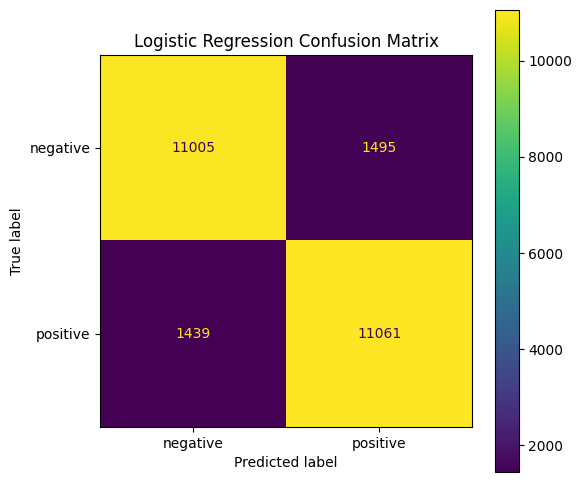

In [7]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=['negative', 'positive'])
disp.plot()
plt.title('Logistic Regression Confusion Matrix')
plt.show()

### Insights (Classical Model)
* **Accuracy** and **F1** usually hover around 0.88‑0.90 on the full IMDb set—excellent for a bag‑of‑words model.
* Most misclassifications come from sarcastic or ambiguous reviews; context is limited in TF‑IDF representations.
* Improving classical models: tune `max_features`, `C` (regularization), and experiment with **Linear SVM**.


## 3  Transformer Inference (DistilBERT)
This section shows how to leverage a pretrained transformer for instant high‑quality sentiment predictions.


In [9]:
pip install transformers

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/10.5 MB ? eta -:--:--
   --- ------------------------------------ 0.8/10.5 MB 4.1 MB/s eta 0:00:03
   ------- -------------------------------- 1.8/10.5 MB 5.1 MB/s eta 0:00:02
   ----------- ---------------------------- 2.9/10.5 MB 4.5 MB/s eta 0:00:02
   -------------- ------------------------- 3.7/10.5 MB 4.4 MB/s eta 0:00:02
   ----------------- ---------------------- 4.5/10.5 MB 4.3 MB/s eta 0:00:02
   -------------------- ------------------- 5.2/10.5 MB 4.2 MB/s eta 0:00:02
   ----------------------- ---------------- 6.0/10.5 MB 4.2 MB/s eta 0:00:02
   -------------------------- ------------- 6.8/10.5 MB 4.1 MB/s eta 0:00:01
   ----------------------------- ---------- 7.6/10.5 MB 4.1 MB/s eta 0:00:01
   -------------------------------- ------- 8.4/10.5 MB 4.1 MB/s eta 0:00:01
   ----------------------------------- ---- 9.2/10.5 MB 4.0 MB/s eta 0:00:01
   --

In [10]:
from transformers import pipeline
sentiment_pipe = pipeline('sentiment-analysis', model='distilbert-base-uncased-finetuned-sst-2-english')

examples = test_ds['text'][:5]
for txt, lbl in zip(examples, y_test[:5]):
    print('-'*60)
    print(txt[:300].replace('\n', ' '), '...')
    print('True label :', 'positive' if lbl==1 else 'negative')
    print('Model pred :', sentiment_pipe(txt)[0])


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

C:\Users\DELL\AppData\Roaming\Python\Python313\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\DELL\.cache\huggingface\hub\models--distilbert-base-uncased-finetuned-sst-2-english. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed.

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cpu


------------------------------------------------------------
I love sci-fi and am willing to put up with a lot. Sci-fi movies/TV are usually underfunded, under-appreciated and misunderstood. I tried to like this, I really did, but it is to good TV sci-fi as Babylon 5 is to Star Trek (the original). Silly prosthetics, cheap cardboard sets, stilted dialogues, C ...
True label : negative
Model pred : {'label': 'NEGATIVE', 'score': 0.999616265296936}
------------------------------------------------------------
Worth the entertainment value of a rental, especially if you like action movies. This one features the usual car chases, fights with the great Van Damme kick style, shooting battles with the 40 shell load shotgun, and even terrorist style bombs. All of this is entertaining and competently handled bu ...
True label : negative
Model pred : {'label': 'NEGATIVE', 'score': 0.6170604825019836}
------------------------------------------------------------
its a totally average film with a fe